<a href="https://colab.research.google.com/github/Alecia113/NLP-Emotional-analysis/blob/main/Ass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5046 Assignment 1
*Make sure you change the file name with your unikey.*

# Readme
*If there is something to be noted for the user, please mention here.* 

*If you are planning to implement a program with Object Oriented Programming style, please check the bottom of the this ipynb file*

***Visualising the comparison of different results is a good way to justify your decision.***

# 1 - Data Preprocessing

## 1.1. Download Dataset

If you want to know how data has been saved in pickle file: see this [ipynb file](https://drive.google.com/file/d/1ZQUVBzgH7N2EbiyE3WTPx7JNe2eRTs36/view?usp=sharing)

In [30]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1lTD6bgRkmwguGAr30v-r0KBPdtnVneLb'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('testing_data.pkl')  

id = '1pCUdlZMoj99UZHtqFeza86fvVQfFmDFX'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training_data.pkl')  

import pickle
training_data = pickle.load(open("training_data.pkl","rb"))
testing_data = pickle.load(open("testing_data.pkl","rb"))

print("------------------------------------")
print("Size of training dataset: {0}".format(len(training_data)))
print("Size of testing dataset: {0}".format(len(testing_data)))
print("------------------------------------")

print("------------------------------------")
print("Sample Data")
print("LABEL: {0} / SENTENCE: {1}".format(training_data[0][0], training_data[0][1]))
print("------------------------------------")


------------------------------------
Size of training dataset: 8000
Size of testing dataset: 2000
------------------------------------
------------------------------------
Sample Data
LABEL: neg / SENTENCE: hopeless for tmr :(
------------------------------------


## 1.2. Preprocess data



*You are required to describe which data preprocessing techniques were conducted with justification of your decision. *

In [31]:
# Please comment your code
#I think of the training set like people taking practice exams. And the test set is equivalent to a final exam. So they should be handled in the same way so that the model effects can be observed effectively.
#[lab5]
import torch
from random import shuffle
import pprint
from nltk.tokenize import TweetTokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
import re

from nltk.tokenize import word_tokenize
from collections import Counter
import math
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Separate data and labels into two lists. As it is the given data set are in the form of data + labels, so to separate it
train_data = [training_data[i][1] for i in range(len(training_data))]
train_label = [training_data[i][0] for i in range(len(training_data))]
test_data = [testing_data[i][1] for i in range(len(testing_data))]  
test_label = [testing_data[i][0] for i in range(len(testing_data))]         #neg pos


# [lab3]random training set To make the model trained better, because the training set given in front of the front is separated before and after 000111, the front is all negative after all positive
# It seems that it is okay not to add it, but the accuracy is improved by adding it. Before adding is to adjust the training set according to the batch_size, otherwise it will appear when training the model, the accuracy of 0.5/1 constant situation. Although the loss is changing, the classification situation remains the same.
zipped = zip(train_data,train_label)                          #The zip function can only be used once. If you print(list(zipped)) directly, zipped will be empty afterwards, because the iterator has already been used once; if you want to reuse the result, you need to save it to a list.
Zipp = list(zipped) 
shuffle(Zipp)
train_data = [context[0] for context in Zipp]
train_label = [context[1] for context in Zipp]


def preprocessing(data_text):
  text = [s.lower() for s in data_text]                       #do preprocessing to lowercase [lab5]. Because it is easier to match elements in the dictionary if they are lowercase. It will not be the case that some words are lowercase and some are uppercase, which makes the data set more neat and makes it easier to delete words for subsequent processing.
  '''
  def remove_punctuation_re(x):                   #Delete the punctuation. 
    x1 = re.sub(r'[^\w\s]','',x)            
    x2 = re.sub(r'\d','',x1)                
    return x2

  text_re = [remove_punctuation_re(s) for s in text]
  '''
  tknzr = TweetTokenizer()
  text_t=[]                               #The set of subwords for each sentence completely. train_t[0][0] each word
  for s in text:                          #text ==text_re
    text = tknzr.tokenize(s)              #Each sentence is split separately text_train[0] split of the first sentence
    text_t.append(text)  
    
                                           #Only the expressions of length 2 and 3 are kept. Because I browsed through the main emojis, I selected the most common ones as reservations.
  def remove(x):
    t = []
    for i in range(len(x)):
      t_sub = []                            #I first thought it was to get my pre-processed words to match up with the positives and negatives in Lexicon, but after investigating and testing, I found it was the equivalent of taking the pre-processed participles and the words in Lexicon, similar to putting them in a comprehensive dictionary.
      for j in range(len(x[i])):            # A new reference dictionary that facilitates model classification training is then formed.
        if len(x[i][j])==0:
          continue
        if x[i][j] == " ":
          continue 
        else:
          x[i][j] = re.sub(r'\d','',x[i][j])                  #delete0-9
          if len(x[i][j]) == 1 or len(x[i][j]) > 3:           #and + or。
            x[i][j] = re.sub(r'[^\w\s+]','', x[i][j])
          if len(x[i][j]) == 0:
            continue 
          else:
            t_sub.append(x[i][j]) 
      t.append(t_sub) 
    return t

  new_text = remove(text_t)

  stop_words = sw.words()                     #stopword: Delete words that are optional and do not affect the meaning of the sentence, but are very numerous. For example, a; an; the.
  sww = sw.words()
  text_stop=[]                        #8000
  for tokens in new_text:             #new_text == text_t
      filtered_sentence = [w for w in tokens if not w in stop_words]
      text_stop.append(filtered_sentence)
  return text_stop

pre_train= preprocessing(train_data)  
pre_test =preprocessing(test_data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Delete Emoji**

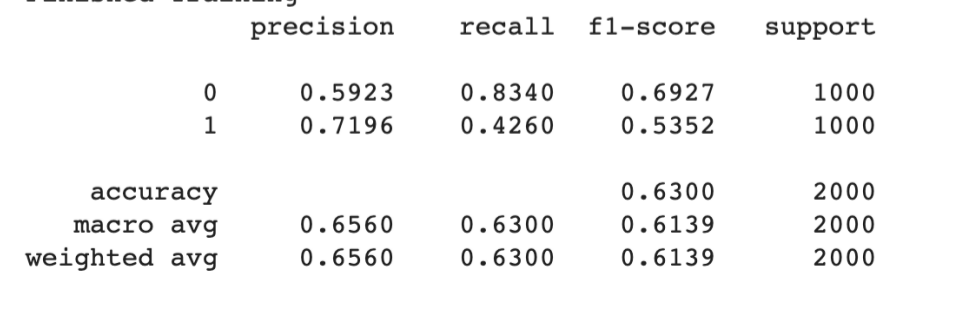

**Keep the expressions of length 2 and 3**

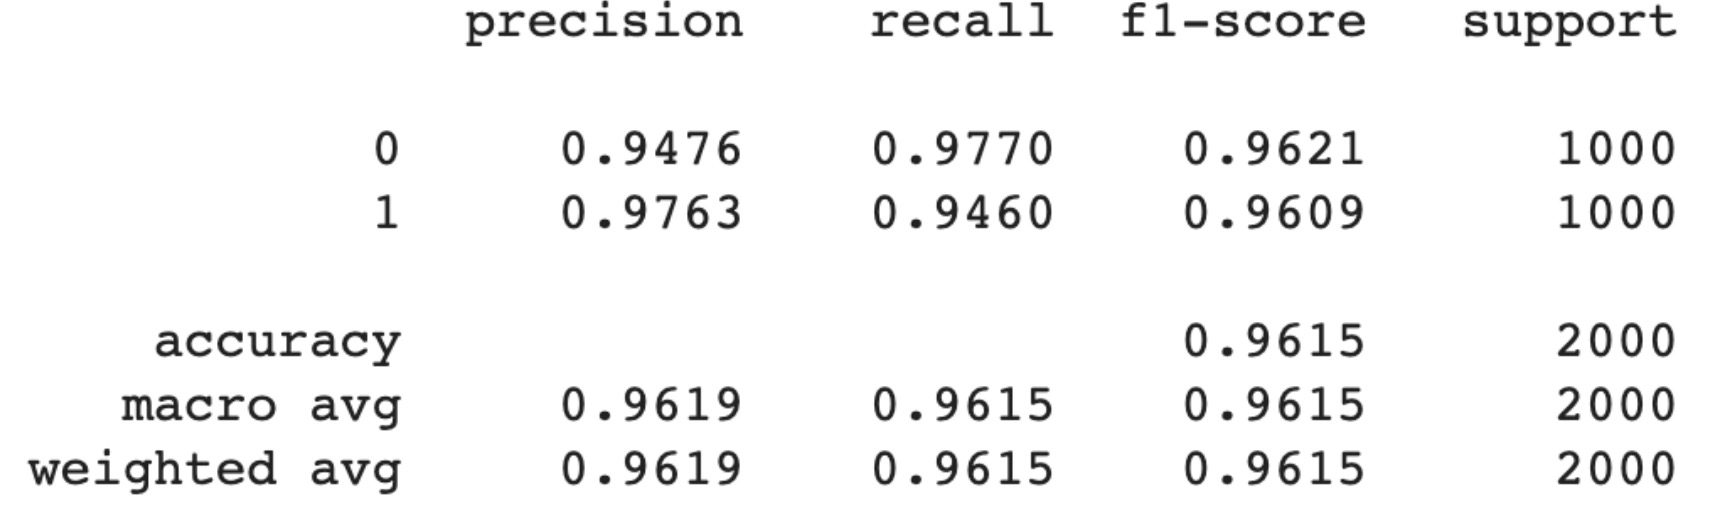

In [32]:
# Why choose stemming not lemmatize: In fact, the difference between the two is not that big, and the performance of stemming is 0.2 more accurate than lemmatize.
#lemmatization, which is the reduction of a linguistic word of any form to a general form (capable of expressing the full semantics), and stemming, which is the extraction of the stem or root form of a word (not necessarily capable of expressing the full semantics). Word form reduction and stemming extraction are the two types of word form normalization.
# That is why the semantic accuracy in Test 3.1 is very low.
#So it depends on the specific requirements. If you want the semantics of the utterance to be more complete, choose lemmatize; but I did not find in the word embedding training (3.1) that the semantics could be preserved with integrity after processing. So I decided to use the processing of stemming to increase the accuracy.
from nltk.stem.porter import *
def stemming(past_text):
  stemmer = PorterStemmer()
  train_stem = []
  for i in range(len(past_text)):
    singles = []
    for plural in past_text[i]:
      singles.append(stemmer.stem(plural))
    train_stem.append(singles)
  return train_stem

stem_train = stemming(pre_train)                  #nobodies -->nobodi
stem_test = stemming(pre_test)

'''
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def lemmatize(past_text):
  lemmatizer = WordNetLemmatizer()

  text_le = []
  for tokens in past_text:
    lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    text_le.append(lemma_sentence)
  return text_le

lem_train = lemmatize(pre_train)  #nobodies-->nobody
lem_test = lemmatize(pre_test)
'''


"\nnltk.download('wordnet')\nfrom nltk.stem import WordNetLemmatizer\n\ndef lemmatize(past_text):\n  lemmatizer = WordNetLemmatizer()\n\n  text_le = []\n  for tokens in past_text:\n    lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens ]\n    text_le.append(lemma_sentence)\n  return text_le\n\nlem_train = lemmatize(pre_train)  #nobodies-->nobody\nlem_test = lemmatize(pre_test)\n"

# 2 - Model Implementation

## 2.1. Word Embeddings

*You are required to describe which model was implemented (i.e. Word2Vec with CBOW, FastText with SkipGram, etc.) with justification of your decision *

I have implemented the FastText with SkipGram model. Because in evaluation 3.1 word_embedding. FastText with SkipGram is more effective than other models for accuracy and Syntactic and Semantic.

**Data Preprocessing for Word Embedding**

  The pre-processing technique here is the same as above.
Since the first part of the processed dataset is used directly, I have explained it clearly in the code of each step above.



**Build word embeddings model**

In [33]:
# Please comment your code [lab2]
#According to 3.1, the effect of skip gram based on FastText is better.
# Use hard coding for naming.
sentences = stem_train + stem_test      # Facilitate training afterwards. Because the final model testing requires a training training set and a testing test set. This is done to facilitate some processing afterwards, such as supplementing the maximum length, etc. This way there is no need to change the overall code.
SIZE= 400
MIN_COUNT = 2                           #will led to OOV problems. Because My model ignores words with a word frequency lower than MIN_COUNT. So these words will not get the vector expression form.
WINDOW = 6
                                        #According to 3.1, it can be inferred that the size of SIZE does not have a significant effect on each word embedding model. It is fluctuating.

from gensim.models import FastText
from gensim.models import Word2Vec

ft_sg_model = FastText(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=1)
ft_sg_model.save('ft_sg.model')
ft_sg = FastText.load("./ft_sg.model")  

#other model (word2vec)
'''
#gensim word2vec #W2V-cbow
wv_cbow_model = Word2Vec(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=0)
wv_cbow_model.wv.save_word2vec_format('ted_cbow_w2v.txt', binary=False)
vectors_wv_cbow="/content/ted_cbow_w2v.txt"    #open

#W2v-skip gram
wv_sg_model = Word2Vec(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=1)
wv_sg_model.wv.save_word2vec_format('ted_sg_w2v.txt', binary=False)
vectors_wv_sg="/content/ted_sg_w2v.txt"   

#FastText- sg

ft_sg_model = FastText(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=1)
ft_sg_model.wv.save_word2vec_format('ted_sg_ft.txt', binary=False)
vectors_ft_sg="/content/ted_sg_ft.txt"    
# fasttext - cbow
ft_cbow_model = FastText(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=0)
ft_cbow_model.wv.save_word2vec_format('ted_cbow_ft.txt', binary=False)
vectors_ft_cbow="/content/ted_cbow_ft.txt"    
'''

#Try to see the effect.
#[lab4][lab2]
#See word
vocab = list(set(ft_sg.wv.vocab.keys()))
print('vocabulary:', len(vocab), vocab[:5])
print('\n')
#Find the set of words that are most similar to a certain word vector.
req_count = 100
for key in ft_sg.wv.similar_by_word('school', topn =100):   #'school'.decode("ISO-8859-1").Words with the five most similar words  
    if len(key[0])==5:  
        req_count -= 1
        print(key[0], key[1])
        if req_count == 0:
            break;
#Check the similarity. Look at the similarity of two words
print(ft_sg.wv.similarity('thing', 'hope'))
print(ft_sg.wv.similarity('phone', 'sleep'))



vocabulary: 4327 ['facebook', 'dd', 'chattsss', 'arriv', 'cut']


laper 0.9998800754547119
super 0.9998518228530884
paper 0.999832034111023
alter 0.9998106956481934
figur 0.9998076558113098
ideal 0.99980628490448
whole 0.9997935891151428
older 0.9997814893722534
steel 0.9997695684432983
duper 0.9997467994689941
tough 0.999736487865448
freak 0.9997087717056274
stone 0.9997052550315857
hyper 0.999683141708374
enter 0.999683141708374
anoth 0.9996430277824402
rider 0.9996172785758972
brain 0.9996169209480286
buyer 0.9995997548103333
burst 0.9995833039283752
drain 0.9995752573013306
river 0.9995664358139038
exist 0.9995218515396118
0.97403806
0.97214335


**Same paramenters different model performance.**

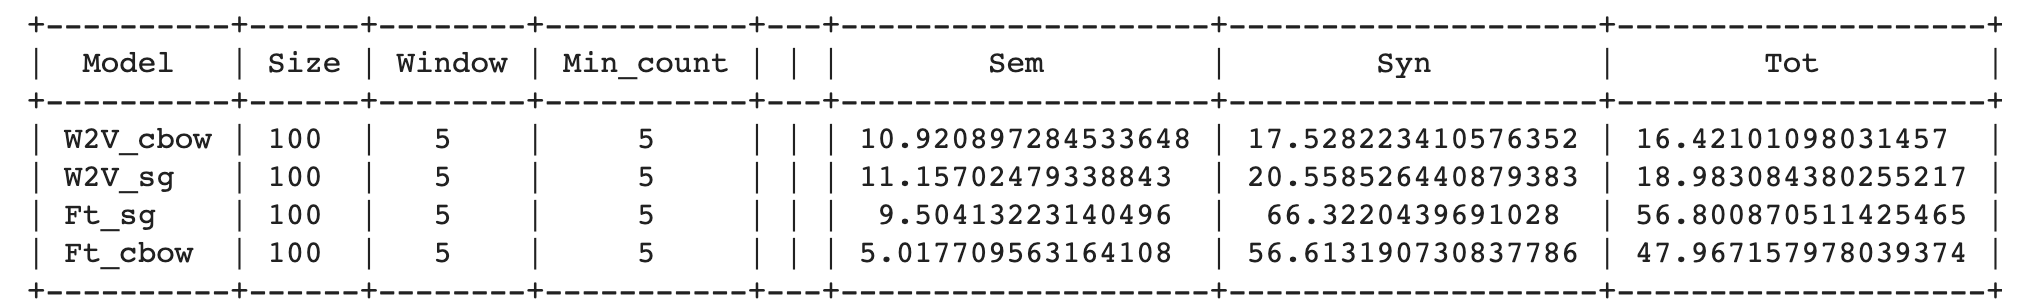

**hyperparameters**

According to the image and data, the Window size is about five or six, and the word vector size is about 400.


Window size

In this small database, in semantics, different window size or words vector size do not high influence.


Semantics, syntax, total, value at window size=[2,4,6,8,10].

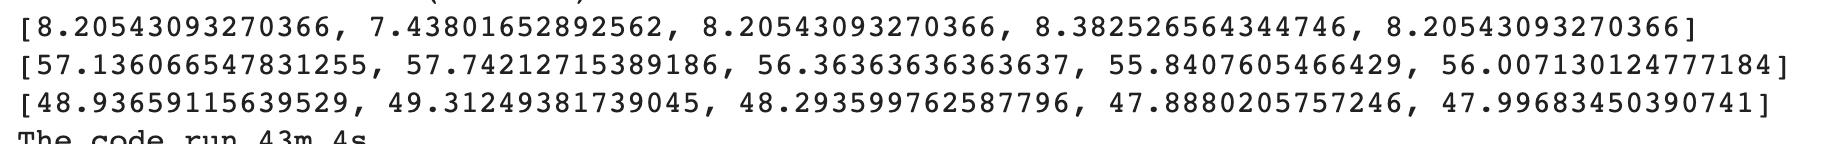

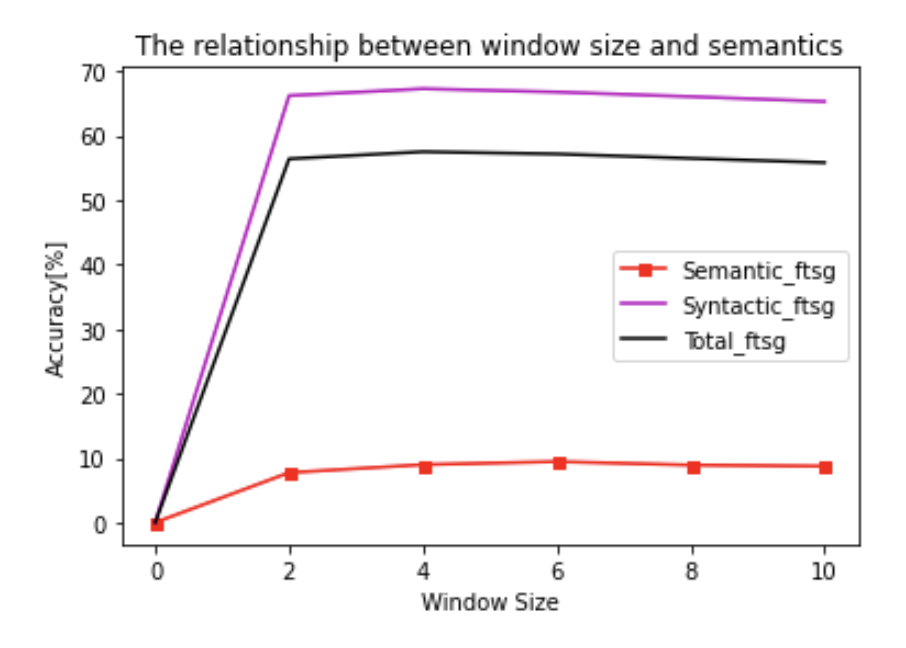

SIZE:
Semantics, syntax, total, value at word vector size=[100,200,300,400,500,600].

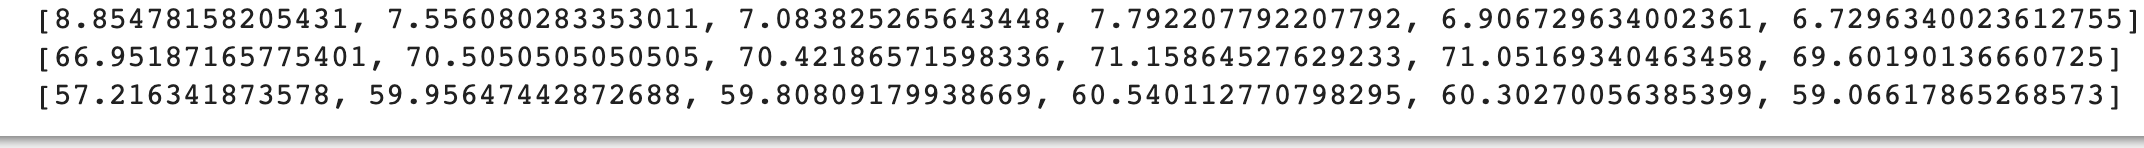

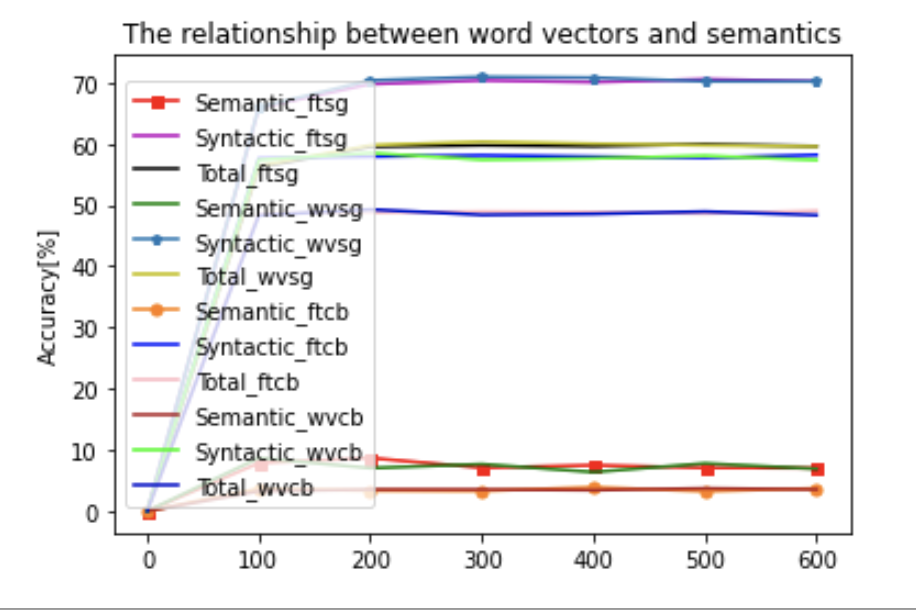

### 2.1.1. Data Preprocessing for Word Embeddings

*You are required to describe which preprocessing techniques were used with justification of your decision.*

In [5]:
# Please comment your code

### 2.1.2. Build Word Embeddings Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

In [6]:
# Please comment your code

### 2.1.3. Train Word Embeddings Model

In [7]:
# Please comment your code

## 2.2. Lexicon Embeddings

### 2.2.1. Lexicon-based Embedding

*[Optional] You are required to describe why you would like to use more than one-dimensional embedding.*

Upload the opinion-lexicon-English document to the drive in Google Cloud Drive. Mount Google Mail. Change the file path.

In [34]:
# Please comment your code
from google.colab import drive
drive.mount('/content/drive') 
#/content/drive/MyDrive/opinion-lexicon-English/negative-words
#/content/drive/MyDrive/opinion-lexicon-English/positive-words
#Based on the review, it was found that there is a document introduction in the provided txt file, so the document needs to be processed.

not_words = [w.strip() for w in open('/content/drive/MyDrive/NLP/A1/E/opinion-lexicon-English/negative-words.txt', 'r', encoding="ISO-8859-1").readlines()]
#Processing documents -
j = -1
for i in not_words:
  j +=1
  if i == '2-faced':
    break
neg = not_words[j:]

#Processing documents -
sure_words = [w.strip() for w in open('/content/drive/MyDrive/NLP/A1/E/opinion-lexicon-English/positive-words.txt', 'r', encoding="ISO-8859-1").readlines()]

j = -1
for i in sure_words:
  j +=1
  if i == 'a+':
    break

pos = sure_words[j:]

#Because the preprocessing method of stemming was chosen to preprocess the dataset, in order to be able to add a feature to the words, we corresponded the tokens in the Twitter_Sample dataset to the words in Lexicon one by one and combined them to form a new dictionary to help the sequence model training. 
#So in order to match, it is also necessary to do stemming on the words in the Lexicon. 
#If the previous dataset is lemmatizer processed, Lexicon should be lemmatizer processed as well.


from nltk.stem.porter import *
def stem(past_text):
  stemmer = PorterStemmer()
  text_le = []
  stemmer_sentence = [stemmer.stem(plural) for plural in past_text ]
  text_le.append(stemmer_sentence)
  return text_le

neg_new = stem(neg)
pos_new = stem(pos)


'''
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


def lem(past_text):
  lemmatizer = WordNetLemmatizer()

  text_le = []

  lemma_sentence = [lemmatizer.lemmatize(w) for w in past_text ]
  text_le.append(lemma_sentence)
  return text_le
neg_new = lem(neg)
pos_new = lem(pos)
'''
#Dictionary embedding; add a dimension of 
#just need to make them correspond first. You have to check whether each word is in the positive or negative dictionary not_exist (0), negative (1) and positive (2)
#One-dimensional sentences, two-dimensional words
#is to turn a sentence into a [012 composed form]
#Now it is the form of one-to-one correspondence.
#It is to replace the original sentence with positive, negative, or non-existent. Prepare for adding FEATURE to it.
#It is just one more FEATURE to make the sequence model easier to train.
def match(text):
  sum_match= []                               #train_match
  for i in range(len(text)):                  #Take out a phrase
    match = []
    for j in range(len(text[i])):             #Take out the words in a sentence
      if text[i][j] in neg_new[0]:            #The first few words of the first sentence
        match.append(1)                       #neg 1
      elif text[i][j] in pos_new[0]:            
        match.append(2)                       #pos 2
      else:
        match.append(0)                       #does not exist
    sum_match.append(match)
  return sum_match

train_match = match(stem_train)               # turn to [0, 2, 0, 0, 1, 0]
test_match = match(stem_test)

#print(train_match)
#print(test_match[:5])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.3. Bi-directional RNN Sequence model

### 2.3.1. Apply/Import Word Embedding and Lexicon Embedding

Tried torch.cat to connect the two tensors, but no luck.
So I guess it should be the reason for the different dimensions, probably the direction of the test after I finish my homework.
So I guess the optional in 2.2: let's give the interpretation of Lexicon embedding in more than one dimension, I think we should make Lexicon also in SIZE size dimension. This way it can be connected using torch.cat.


In [35]:
# Concatenate the train word embedding + lexicon embedding
#[lab1]Here the problem of OOV arises. As I mentioned before, because I ignored some words with very low word frequency and did not train word vectors for them. 
#So here I used the DF approach and ignored these words to avoid the OOV problem.

def input(text,text_match):
  DF = {}

  for tokensized_doc in text: 
      for term in np.unique(tokensized_doc):    # get each unique word in the doc - and count the number of occurrences in the document
          try:
              DF[term] +=1
          except:
              DF[term] =1
  input = []                                   #DF The word frequency of the entire statistic. Keep the words with DF greater than MIN_COUNT. If DF[term] >= MIN_COUNT, I re-add.
  for w in range(len(text)):                   #8000 0-7999
    num = 0
    new = []
    for t in text[w]:                          #In a word #t is the word  #13
      match = []                               #This is currently the first sentence of match
      if DF[t] >= MIN_COUNT:                   #0-12     min_count  //2
        word_vec = ft_sg[t].tolist()
        match.append(text_match[w][num])       #w 012 []   #IndexError: list index out of range 后面的num问题
        new_embedding = word_vec + match       #sent_embedding
        new.append(new_embedding)
      num += 1
      if num >= len(text_match[w]):
        break
    input.append(new)                          #print(input[0][0]) #input 8000 one sentence 3 one word 401  vec+0、1、2；Because an additional dimension was added to add Lexicon to it.
  return input

input_train = input(stem_train,train_match)        
input_test = input(stem_test,test_match)          
#pprint.pprint(input_train[:1])
#print('\n')
#pprint.pprint(input_test[:1])

**build the hard cord**

In [36]:
#get : n_class[lab5]
#Here it also leads to the problem that the tags do not correspond later.
unique_labels = np.unique(train_label)

lEnc = LabelEncoder()
label_train_encoded = lEnc.fit_transform(train_label)         #lEnc.transform(unique_labels)[0]+1
label_test_encoded = lEnc.fit_transform(test_label)
n_class = len(unique_labels)                                  

#maxlength [lab4] idea from[lab5]
#Because what is thrown into the sequence model are sentences that are to be of uniform length. For convenience, I set the sentence directly to the longest sentence length.
#This way only the zeros need to be made up, no deleting. 
doc_length_list = []                                              
sum_text = sentences                                           #sentences = stem_train + stem_test  
maxlength = 0
for doc in sum_text:
    doc_length_list.append(len(doc))                           #how many tokens every sentences 

for index in range(len(doc_length_list)):
  if doc_length_list[index] > maxlength:
    maxlength = doc_length_list[index]
    max_index = index
#print(doc_length_list[max_index])                              #22  doc_length_list


#[lab4][lab5]
#Check that the number of output nodes matches the number of labels.
# and change the number of output nodes num_outputs to the number of labels.
#Because the class category I set before is 0,1; so I need to change it to 0,1 or else there will be a target out of range error later.
def label(label):   
  label = np.array(label)                                     #train_label #neg 1 pos2                                                              #neg 1 pos2
  lab = []                                                    
  for tag in label:
    if tag == 'neg':
      lab.append(0)
    else:
      lab.append(1)
  #print(label_train)
  #print(len(label_train))
  lab = np.array(lab)
  return lab

label_train = label(train_label)
label_test = label(test_label)


### 2.3.2. Build Sequence Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

The reason for the initial mediation of batch_size, learning_rate, etc. is that I did not randomly disrupt the initial dataset at the beginning, and each epoch of the training set was constant at 0.5 or 1. This is because of the sample distribution problem. The first half of the sample distribution is negative and the second half is positive. For example, if it is determined to be positive class, then it proves that my batch_size is too big or my learning rate is too small. So according to my debugging, the learning rate evaluation of 3.3 was performed again. Regarding epoch, I found it when comparing Bi-RNN and Bi-LSTM models. When epoch is small, Bi-RNN outperforms Bi-LSTM, but when epoch is expanded, Bi-LSTM has a clear advantage. 


In [49]:
#hyperparameters[lab5]
seq_length = doc_length_list[max_index]           #（22）
n_input = len(input_train[0][0])              #401 Because an additional dimension was added to add Lexicon to it.
n_class = len(unique_labels)                  #2

n_hidden = 232                                  #128,200
batch_size = 512                                #500 ,800
total_epoch = 20                                #10,20
learning_rate = 0.001                           # 1e-4 == 0.001 le-3 == 0.01 #0.1  0.05;0.01
  

#idea from [lab5] Take the input specifications and make them all the same, so that the sentence length is 22 and the word dimension is 401

def sent_encoded(input_text):
  sent_encoded = []
  for m in range(len(input_text)):                                               
    
    encoded = [] 
    zero = []
    if len(input_text[m]) < seq_length:
      zero = [len(input_text[0][0])*[0]] * (seq_length - len(input_text[m]))    #Add to 22 longest # not just add 0; still needs to become 401 dimensions
      encoded = input_text[m] + zero
    else:
      encoded = input_text[m]
    sent_encoded.append(encoded)                                                #To re-add. The sentences have all become 22 

  sent_encoded = np.array(sent_encoded)
  return sent_encoded

sent_encoded_train = sent_encoded(input_train)
sent_encoded_test = sent_encoded(input_test)
#print(sent_encoded_train[:1]) #(8000, 22, 101)
#print(sent_encoded_test[:1])#(2000, 22, 101)


#Still Bi-LSTM is more accurate because LSTM deals with the problem of memory loss.
#In essence, RNN cannot deal with the problem of too long sequence models, and RNN will forget some important information at the beginning.
#And LSTM solves the forgetting problem. Bi-sequence model is designed to better solve the problem of understanding semantics using context.

#LSTM-BI[lab5]
class Bi_LSTM_Model(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Model, self).__init__()
        #self.emb = nn.Embedding(vocab_size, emb_dim)
        # Initialize the Embedding layer with the lookup table we created 
        #self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        #self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        #x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        lstm_out, (h_n,c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

#Bi-LSTM
# Move the model to GPU
criterion = nn.CrossEntropyLoss()
model = Bi_LSTM_Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



# Bi-RNN sequence model [lab4]
'''
class Bi_RNN_Model(nn.Module):
    def __init__(self):
        super(Bi_RNN_Model, self).__init__()
        # set the bidirectional to True
        self.rnn = nn.RNN(n_input, n_hidden, batch_first =True, bidirectional=True)       #, dropout = 0.5
        self.linear = nn.Linear(2*n_hidden,n_class) #n_class = 3 
          
    def forward(self, x):        
        x, h_n = self.rnn(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        output = self.linear(hidden_out)
        return output

criterion = nn.CrossEntropyLoss()
model = Bi_RNN_Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
'''




'\nclass Bi_RNN_Model(nn.Module):\n    def __init__(self):\n        super(Bi_RNN_Model, self).__init__()\n        # set the bidirectional to True\n        self.rnn = nn.RNN(n_input, n_hidden, batch_first =True, bidirectional=True)       #, dropout = 0.5\n        self.linear = nn.Linear(2*n_hidden,n_class) #n_class = 3 \n          \n    def forward(self, x):        \n        x, h_n = self.rnn(x)\n        # concat the last hidden state from two direction\n        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)\n        output = self.linear(hidden_out)\n        return output\n\ncriterion = nn.CrossEntropyLoss()\nmodel = Bi_RNN_Model().to(device)\noptimizer = optim.Adam(model.parameters(), lr=learning_rate)\n'

**epoch == 20; F1-score of Bi-LSTM bigger than F1-score of Bi-RNN**

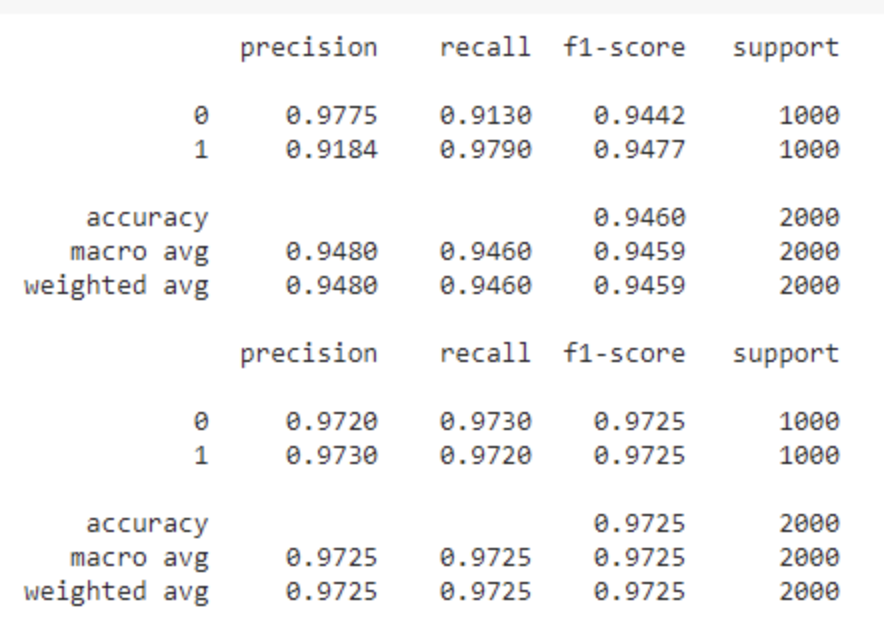

### 2.3.3. Train Sequence Model

Note that it will not be marked if you do not display the Training Loss and the Number of Epochs in the Assignment 1 ipynb.


In [50]:
# zero the parameter gradients
# forward + backward + optimize
#[lab4][lab5]
#Bi-LSTM
# Move the model to GPU
criterion = nn.CrossEntropyLoss()
model = Bi_LSTM_Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,sent_encoded_train.shape[0],batch_size):
        input_batch = sent_encoded_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])]  #sent_encoded_train = sent_encoded(input_train)
        target_batch = label_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])]  
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)  
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device) 

        model.train()
        optimizer.zero_grad()
        outputs = model(input_batch_torch)   
        loss = criterion(outputs, target_batch_torch) 
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    predicted = torch.argmax(outputs, 1)                                                      # The output value is the meta ancestor to get the second tensor        
    acc = accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
    print('Epoch: %d, train loss: %.5f, train_acc:%.2f'%(epoch + 1, train_loss, acc))

print('Finished Training')

# # Prediction

# model.eval()
# outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device))                      #sent_encoded_test = sent_encoded(input_test)
# predicted2 = torch.argmax(outputs2, 1)
# print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))

Epoch: 1, train loss: 9.93011, train_acc:0.83
Epoch: 2, train loss: 6.62112, train_acc:0.90
Epoch: 3, train loss: 4.43551, train_acc:0.91
Epoch: 4, train loss: 3.49756, train_acc:0.94
Epoch: 5, train loss: 2.72364, train_acc:0.94
Epoch: 6, train loss: 2.44917, train_acc:0.95
Epoch: 7, train loss: 2.11877, train_acc:0.97
Epoch: 8, train loss: 1.93843, train_acc:0.96
Epoch: 9, train loss: 1.79770, train_acc:0.96
Epoch: 10, train loss: 1.65233, train_acc:0.97
Epoch: 11, train loss: 1.47282, train_acc:0.97
Epoch: 12, train loss: 1.39473, train_acc:0.97
Epoch: 13, train loss: 1.26967, train_acc:0.97
Epoch: 14, train loss: 1.17909, train_acc:0.98
Epoch: 15, train loss: 1.22664, train_acc:0.97
Epoch: 16, train loss: 1.04284, train_acc:0.98
Epoch: 17, train loss: 1.08203, train_acc:0.98
Epoch: 18, train loss: 1.04836, train_acc:0.98
Epoch: 19, train loss: 0.94255, train_acc:0.98
Epoch: 20, train loss: 0.99951, train_acc:0.98
Finished Training


# 3 - Evaluation


## 3.1. Word Embedding Evaluation
You are to apply Semantic-Syntactic word relationship tests for the trained word embeddings and visualise the result of Semantic-Syntactic word relationship tests.
Note that it will not be marked if you do not display it in the ipynb file.


(*Please show your empirical evidence*)
* I think we only need to prove which word embedding is better, so just make sure to compare the performance of these models with other things being equal.
* When I use the same parameters, the Festtext-skip gram model outperforms Word2vec-CBOW, Word2vec-Skip gram, and Festtext-Cbow, especially in terms of overall accuracy and syntax. However, Word2Vec still performs better than Festtext in terms of semantics. The accuracy is higher because when a word is not available in the corpus, Festtext will split the word and find it separately. For example, two two-letter groups. This can give word embedding to some words that are not in the corpus, but the disadvantage of this is that it can lead to semantic bias.
* Skip-gram is semantically and syntactically better than Cbow, because it infers edge words from central words. The core of a sentence is the central word. The central word can express the semantics better.
* These models do not have much effect with word vector dimension and Window size. I guess it's because the dataset is still too small. So it doesn't change much.
* I have pasted the image below the corresponding implementation code, so if you want to try it you can remove the comments and try it.

Tip: Run the evaluation program. Prone to excessive slowdowns and program crashes.


In [13]:
# Please comment your code
#To test with semantic, syntactic word relations. [lab5-word_analogy_evaluation]
#https://colab.research.google.com/drive/1VdNkQpeI6iLPHeTsGe6sdHQFcGyV1Kmi?usp=sharing#scrollTo=EVk7tjwvhl-6

import numpy as np
import re
from lxml import etree 
import pprint
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



id = '1B47OiEiG2Lo1jUY6hy_zMmHBxfKQuJ8-'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ted_en-20160408.xml')  



#data preprocessing
targetXML=open('ted_en-20160408.xml', 'r', encoding='ISO-8859-1')
target_text = etree.parse(targetXML)
parse_text = '\n'.join(target_text.xpath('//content/text()'))
content_text = re.sub(r'\([^)]*\)', '', parse_text)
sent_text=sent_tokenize(content_text)

normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

sentences=[]
sentences=[word_tokenize(sentence) for sentence in normalized_text]

# Prints only 10 (tokenised) sentences
#print(sentences[:10])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
#gensim word2vec #W2V-cbow
SIZE= 100
MIN_COUNT = 5
WINDOW = 5
wv_cbow_model = Word2Vec(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=0)
wv_cbow_model.wv.save_word2vec_format('ted_cbow_w2v.txt', binary=False)
vectors_wv_cbow="/content/ted_cbow_w2v.txt"   

#W2v-skip gram
wv_sg_model = Word2Vec(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=1)
wv_sg_model.wv.save_word2vec_format('ted_sg_w2v.txt', binary=False)
vectors_wv_sg="/content/ted_sg_w2v.txt"    

#FastText- sg
from gensim.models import FastText
ft_sg_model = FastText(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=1)
ft_sg_model.wv.save_word2vec_format('ted_sg_ft.txt', binary=False)
vectors_ft_sg="/content/ted_sg_ft.txt"   

# fasttext - cbow
ft_cbow_model = FastText(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=0)
ft_cbow_model.wv.save_word2vec_format('ted_cbow_ft.txt', binary=False)
vectors_ft_cbow="/content/ted_cbow_ft.txt"    



In [15]:
#match
def open_files(file_name):
  with open(file_name, 'r') as f:    #vectors_file == vectors_wv_cbow  ==file_name
    vectors = {}
    for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
      vals = line.rstrip().split(' ')
      vectors[vals[0]] = [x for x in vals[1:]]


  vocab_words=list(vectors.keys())
  vocab_size = len(vocab_words)
  print("Vocab size: ",str(vocab_size))

  # create word->index and index->word converter  
  vocab = {w: idx for idx, w in enumerate(vocab_words)}   #every word match an index
  ivocab = {idx: w for idx, w in enumerate(vocab_words)} 


  # create the embedding matrix of shape (vocab_size, dim)
  vector_dim = len(vectors[ivocab[0]])                    #100
  W = np.zeros((vocab_size, vector_dim))                  #4325.100
  for word, v in vectors.items():
      if word == '<unk>' or word == '':   
          continue
      
      W[vocab[word], :] = v                               #100 102

  # normalize each word vector to unit length
  # Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
  W_norm = np.zeros(W.shape)
  d = (np.sum(W ** 2, 1) ** (0.5))
  W_norm = (W.T / d).T
  
  return W, vocab, W_norm
#W, vocab

W1,vocab1,W1_norm = open_files(vectors_wv_cbow)           #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow
W2,vocab2,W2_norm = open_files(vectors_wv_sg)             #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow
W3,vocab3,W3_norm = open_files(vectors_ft_sg)             #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow
W4,vocab4,W4_norm = open_files(vectors_ft_cbow)           #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow

Vocab size:  21613
Vocab size:  21613
Vocab size:  21613
Vocab size:  21613


In [16]:
#Start syntactic text analysis of various functional statements.
!git clone https://github.com/stanfordnlp/GloVe.git
def evaluate_vectors(W, vocab, prefix='./content/GloVe/eval/question-data/'):#/content/GloVe/eval/question-data
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100

    correct_sem = 0;                                                        # count correct semantic questions  
    correct_syn = 0;                                                        # count correct syntactic questions 
    correct_tot = 0                                                         # count correct questions   
    count_sem = 0;                                                          # count all semantic questions 
    count_syn = 0;                                                          # count all syntactic questions  
    count_tot = 0                                                           # count all questions     
    full_count = 0                                                          # count all questions, including those with unknown words    

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]

        if len(data) == 0:
            print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            print("Example missing line:", full_data[0])
            continue

        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])

            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)


            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()

        
        val = (ind4 == predictions)                                            # correct predictions
        count_tot = count_tot + len(ind1)                                      #216
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)

        print("%s:" % filenames[i])
        print('ACCURACY TOP1: %.2f%% (%d/%d)' %
            (np.mean(val) * 100, np.sum(val), len(val)))
        
    return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count
'''
#Visualization display
correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')#/content/GloVe/eval/question-data
print('Questions seen/total: %.2f%% (%d/%d)' %    
    (100 * count_tot / float(full_count), count_tot, full_count))
print('Semantic accuracy: %.2f%%  (%i/%i)' %  
    (100 * correct_sem / float(count_sem), correct_sem, count_sem))
print('Syntactic accuracy: %.2f%%  (%i/%i)' % 
    (100 * correct_syn / float(count_syn), correct_syn, count_syn))
print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))

'''

Cloning into 'GloVe'...
remote: Enumerating objects: 595, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 595 (delta 0), reused 1 (delta 0), pack-reused 592
Receiving objects: 100% (595/595), 222.33 KiB | 12.35 MiB/s, done.
Resolving deltas: 100% (338/338), done.


"\n#Visualization display\ncorrect_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')#/content/GloVe/eval/question-data\nprint('Questions seen/total: %.2f%% (%d/%d)' %    \n    (100 * count_tot / float(full_count), count_tot, full_count))\nprint('Semantic accuracy: %.2f%%  (%i/%i)' %  \n    (100 * correct_sem / float(count_sem), correct_sem, count_sem))\nprint('Syntactic accuracy: %.2f%%  (%i/%i)' % \n    (100 * correct_syn / float(count_syn), correct_syn, count_syn))\nprint('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))\n\n"

In [17]:
# 1-vectors_wv_cbow； 2-vectors_wv_sg； 3-vectors_ft_sg； 4vectors_ft_cbow
def show_answer(W_norm,vocab):
  #Visualization display
  correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')#/content/GloVe/eval/question-data
  Semantic = 100 * correct_sem / float(count_sem)
  Syntactic = 100 * correct_syn / float(count_syn)
  Total = 100 * correct_tot / float(count_tot)
  return Semantic, Syntactic, Total
  #overall
Semantic_wv_cbow, Syntactic_wv_cbow, Total_wv_cbow = show_answer(W1_norm, vocab1)
print(Total_wv_cbow)
print('\n')
Semantic_wv_sg, Syntactic_wv_sg, Total_wv_sg = show_answer(W2_norm, vocab2)
print(Total_wv_sg)
print('\n')
Semantic_ft_sg, Syntactic_ft_sg, Total_ft_sg = show_answer(W3_norm, vocab3)
print(Total_ft_sg)
print('\n')
Semantic_ft_cbow, Syntactic_ft_cbow, Total_ft_cbow = show_answer(W4_norm, vocab4)
print(Total_ft_cbow)

capital-common-countries.txt:
ACCURACY TOP1: 6.25% (17/272)
capital-world.txt:
ACCURACY TOP1: 4.34% (22/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 1.28% (7/545)
family.txt:
ACCURACY TOP1: 48.54% (166/342)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 2.09% (17/812)
gram2-opposite.txt:
ACCURACY TOP1: 1.78% (9/506)
gram3-comparative.txt:
ACCURACY TOP1: 31.83% (424/1332)
gram4-superlative.txt:
ACCURACY TOP1: 9.79% (74/756)
gram5-present-participle.txt:
ACCURACY TOP1: 36.49% (362/992)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 2.47% (21/849)
gram7-past-tense.txt:
ACCURACY TOP1: 21.39% (317/1482)
gram8-plural.txt:
ACCURACY TOP1: 16.67% (155/930)
gram9-plural-verbs.txt:
ACCURACY TOP1: 17.46% (132/756)
17.044218023543376


capital-common-countries.txt:
ACCURACY TOP1: 4.04% (11/272)
capital-world.txt:
ACCURACY TOP1: 1.97% (10/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 3.30% (18/545)
family.txt:
ACCURACY TOP1: 42.9

In [18]:
#table
from prettytable import PrettyTable
x = PrettyTable(['Model','Size','Window','Min_count','|','Sem','Syn','Tot'])
x.align['Model'] = '1'                                                                       #Left-aligned with model fields
x.padding_width = 1                                                                          #Fill Fast Read
x.add_row(['W2V_cbow','100','5','5','|',Semantic_wv_cbow, Syntactic_wv_cbow, Total_wv_cbow])
x.add_row(['W2V_sg  ','100','5','5','|',Semantic_wv_sg, Syntactic_wv_sg, Total_wv_sg])
x.add_row(['Ft_sg   ','100','5','5','|',Semantic_ft_sg, Syntactic_ft_sg, Total_ft_sg])
x.add_row(['Ft_cbow ','100','5','5','|',Semantic_ft_cbow, Syntactic_ft_cbow, Total_ft_cbow])
print(x)

+----------+------+--------+-----------+---+--------------------+--------------------+--------------------+
|  Model   | Size | Window | Min_count | | |        Sem         |        Syn         |        Tot         |
+----------+------+--------+-----------+---+--------------------+--------------------+--------------------+
| W2V_cbow | 100  |   5    |     5     | | | 12.514757969303425 | 17.956030897207366 | 17.044218023543376 |
| W2V_sg   | 100  |   5    |     5     | | | 10.979929161747343 | 20.487225193107545 |  18.8940548026511  |
| Ft_sg    | 100  |   5    |     5     | | |  8.9728453364817   | 68.40166369578134  | 58.44297160945692  |
| Ft_cbow  | 100  |   5    |     5     | | | 5.076741440377804  | 57.49257278669043  | 48.70907112474033  |
+----------+------+--------+-----------+---+--------------------+--------------------+--------------------+


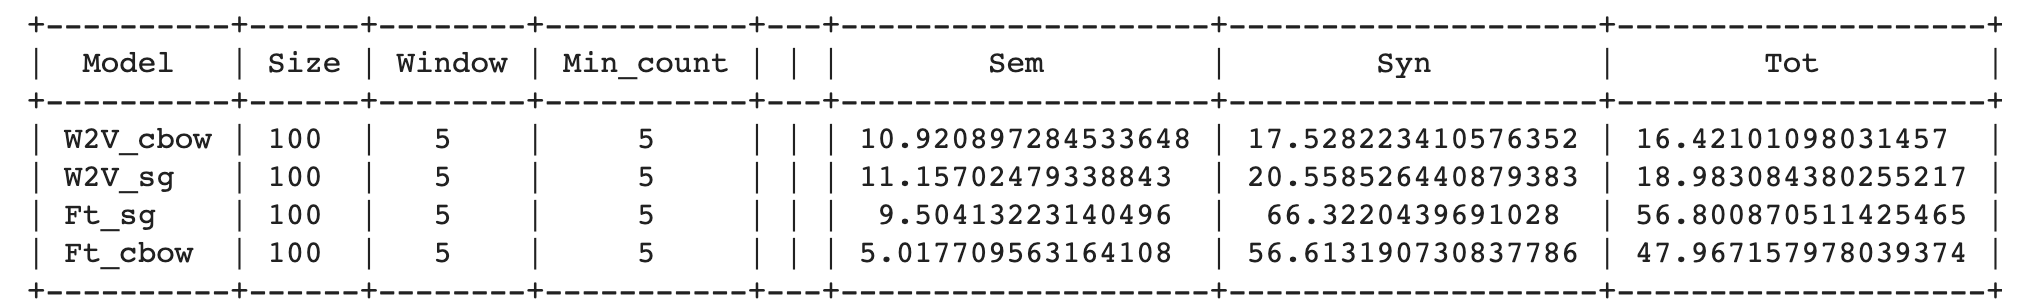

different size

In [19]:
#Ft_sg 2h
def size_change(name, sgn):
  size = [100,200,300,400,500,600] #x
  MIN_COUNT = 5
  WINDOW = 10
  Sem_test = []
  Syn_test = []
  Tot_test = []
  for s_size in range(len(size)):
    SIZE = size[s_size]
    size_change = name(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg = sgn) #FastText
    size_change.wv.save_word2vec_format('size_change.txt', binary=False)
    vectors="/content/size_change.txt"    

    W_test,vocab_test,W_test_norm = open_files(vectors)
    Semantic_test, Syntactic_test, Total_test = show_answer(W_test_norm, vocab_test)
    Sem_test.append(Semantic_test)
    Syn_test.append(Syntactic_test)
    Tot_test.append(Total_test)
  return Sem_test, Syn_test, Tot_test


#Sem_ftsg, Syn_ftsg, Tot_ftsy = size_change(FastText,1)


# print(Sem_ftsg)
# print(Syn_ftsg)
# print(Tot_ftsg) 
#y=accuary

Sem_ftsg, Syn_ftsg, Tot_ftsy = size_change(FastText,1)
#Sem_ftcb, Syn_ftcb, Tot_ftcb = size_change(FastText,0)
#Sem_wvcb, Syn_wvcb, Tot_wvcb = size_change(FastText,0)
#Sem_wvsg, Syn_wvsg, Tot_wvsy = size_change(FastText,1)

Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 1.47% (4/272)
capital-world.txt:
ACCURACY TOP1: 1.97% (10/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 1.83% (10/545)
family.txt:
ACCURACY TOP1: 36.26% (124/342)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 73.40% (596/812)
gram2-opposite.txt:
ACCURACY TOP1: 74.70% (378/506)
gram3-comparative.txt:
ACCURACY TOP1: 77.63% (1034/1332)
gram4-superlative.txt:
ACCURACY TOP1: 83.73% (633/756)
gram5-present-participle.txt:
ACCURACY TOP1: 78.93% (783/992)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 44.76% (380/849)
gram7-past-tense.txt:
ACCURACY TOP1: 36.71% (544/1482)
gram8-plural.txt:
ACCURACY TOP1: 72.58% (675/930)
gram9-plural-verbs.txt:
ACCURACY TOP1: 73.28% (554/756)
Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 1.10% (3/272)
capital-world.txt:
ACCURACY TOP1: 2.37% (12/507)
currency.txt:
ACCURACY TOP1: 3.57% (1/28)
city-in-state.txt:
ACCURACY TOP1: 4.04% (22/545)
famil

In [20]:
def appdd(name1,name2,name3):
  l1 = [0]
  l2 = [0]
  l3 = [0]
  for i in range(6):
    l1.append(name1[i])
    l2.append(name2[i])
    l3.append(name3[i])
  return l1, l2, l3

l1, l2, l3 = appdd(Sem_ftsg,Syn_ftsg,Tot_ftsy)
# l4, l5, l6 = appdd(Sem_wvsg,Syn_wvsg,Tot_wvsy)
# l7, l8, l9 = appdd(Sem_ftcb,Syn_ftcb,Tot_ftcb)
# l10, l11, l12 = appdd(Sem_wvcb,Syn_wvcb,Tot_wvcb)

In [ ]:
import matplotlib.pyplot as plt
x = [0,100,200,300,400,500,600]                                      #7
ys1 = [Semantic for Semantic in l1]
ys2 = [Syntactic for Syntactic in l2]
ys3 = [Total for Total in l3]
plt.plot(x,ys1,'rs-',markersize =5,label = 'Semantic_ftsg')
plt.plot(x,ys2,'m-',markersize =5,label = 'Syntactic_ftsg')
plt.plot(x,ys3,'k-',markersize =5,label = 'Total_ftsg')
# ys4 = [Semantic for Semantic in l4]
# ys5 = [Syntactic for Syntactic in l5]
# ys6 = [Total for Total in l6]
# plt.plot(x,ys4,'g-',markersize =5,label = 'Semantic_wvsg')
# plt.plot(x,ys5,'p-',markersize =5,label = 'Syntactic_wvsg')
# plt.plot(x,ys6,'y-',markersize =5,label = 'Total_wvsg')

# ys7= [Semantic for Semantic in l7]
# ys8 = [Syntactic for Syntactic in l8]
# ys9 = [Total for Total in l9]
# plt.plot(x,ys7,'o-',markersize =5,label = 'Semantic_ftcb')
# plt.plot(x,ys8,'b-',markersize =5,label = 'Syntactic_ftcb')
# plt.plot(x,ys9,'#FFB6C1',markersize =5,label = 'Total_ftcb')

# ys10 = [Semantic for Semantic in l10]
# ys11 = [Syntactic for Syntactic in l11]
# ys12 = [Total for Total in l12]
# plt.plot(x,ys10,'#B22222',markersize =5,label = 'Semantic_wvcb')
# plt.plot(x,ys11,'#00FF00',markersize =5,label = 'Syntactic_wvcb')
# plt.plot(x,ys12,'#0000CD',markersize =5,label = 'Total_wvcb')

plt.xlabel('Size')
plt.ylabel('Accuracy[%]')
plt.title('The relationship between word vectors and semantics')
plt.legend()
plt.show()



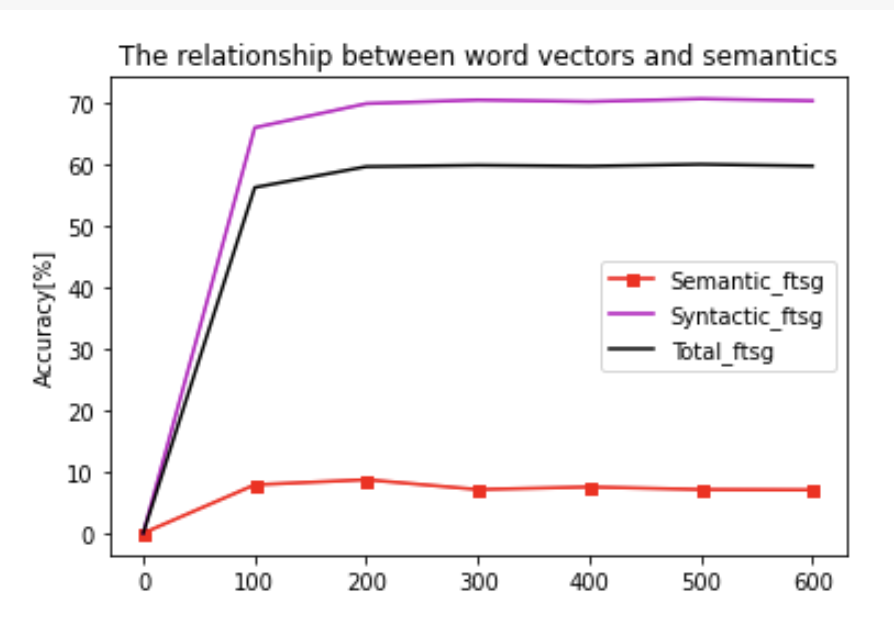

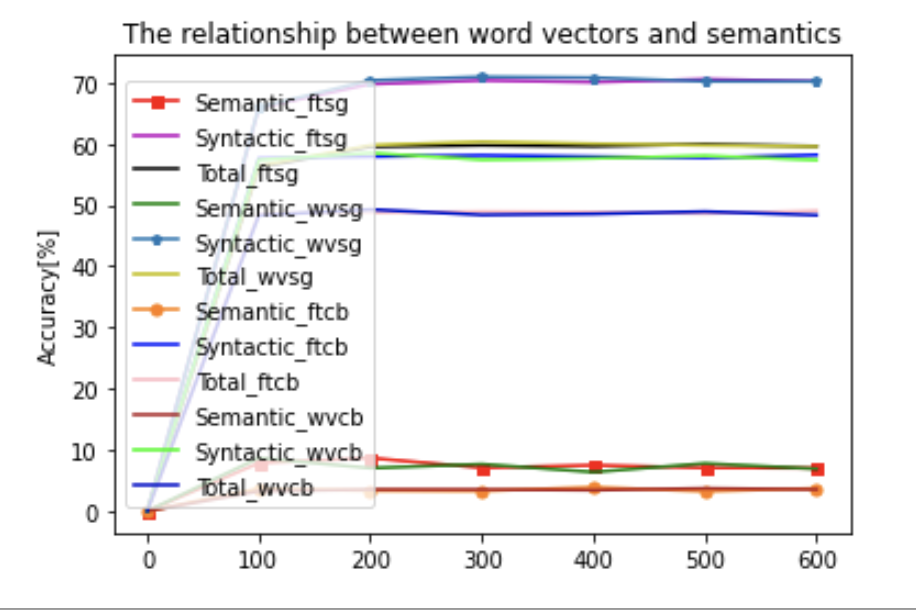

different window size

In [26]:
#Ft_sg

import time
since = time.time()
def win_change(name,sgn):
  SIZE = 100                                      #x
  MIN_COUNT = 5
  WINDOW = [2,4,6,8,10]
  Sem_win = []
  Syn_win = []
  Tot_win = []
  for win in range(len(WINDOW)):
    WINDOW1 = WINDOW[win]
    test_win = name(sentences=sentences, size=SIZE, window=WINDOW1, min_count=MIN_COUNT, workers=2, sg=sgn)
    test_win.wv.save_word2vec_format('test_win.txt', binary=False)
    vectors_win="/content/test_win.txt"    

    W_test,vocab_test,W_test_norm = open_files(vectors_win)
    Semantic_win, Syntactic_win, Total_win= show_answer(W_test_norm, vocab_test)
    Sem_win.append(Semantic_win)
    Syn_win.append(Syntactic_win)
    Tot_win.append(Total_win)
  
  return Sem_win, Syn_win, Tot_win

  
# print(Sem_win_ftsg)
# print(Syn_win_ftsg)
# print(Tot_win_ftsg)
time_elapsed = time.time() - since
print('The code run {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#y=accuary


The code run 0m 0s


In [27]:
# Sem_win_wvsg, Syn_win_wvsg, Tot_win_wvsy = win_change(FastText,1)
# Sem_win_ftcb, Syn_win_ftcb, Tot_win_ftcb = win_change(FastText,0)
# Sem_win_wvcb, Syn_win_wvcb, Tot_win_wvcb = win_change(FastText,0)
Sem_win_ftsg, Syn_win_ftsg, Tot_win_ftsy = win_change(FastText,1)
def appd(name1,name2,name3):
  k1 = [0]
  k2 = [0]
  k3 = [0]
  for i in range(5):
    k1.append(name1[i])
    k2.append(name2[i])
    k3.append(name3[i])
  return k1, k2, k3

k1, k2, k3 = appd(Sem_win_ftsg,Syn_win_ftsg,Tot_win_ftsy)
# k4, k5, k6 = appd(Sem_win_wvsg,Syn_win_wvsg,Tot_win_wvsy)
# k7, k8, k9 = appd(Sem_win_ftcb,Syn_win_ftcb,Tot_win_ftcb)
# k10, k11, k12 = appd(Sem_win_wvcb,Syn_win_wvcb,Tot_win_wvcb)

Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 1.10% (3/272)
capital-world.txt:
ACCURACY TOP1: 2.17% (11/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 1.28% (7/545)
family.txt:
ACCURACY TOP1: 30.70% (105/342)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 80.91% (657/812)
gram2-opposite.txt:
ACCURACY TOP1: 85.97% (435/506)
gram3-comparative.txt:
ACCURACY TOP1: 79.58% (1060/1332)
gram4-superlative.txt:
ACCURACY TOP1: 88.62% (670/756)
gram5-present-participle.txt:
ACCURACY TOP1: 82.46% (818/992)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 32.04% (272/849)
gram7-past-tense.txt:
ACCURACY TOP1: 33.94% (503/1482)
gram8-plural.txt:
ACCURACY TOP1: 63.66% (592/930)
gram9-plural-verbs.txt:
ACCURACY TOP1: 76.98% (582/756)
Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 1.10% (3/272)
capital-world.txt:
ACCURACY TOP1: 1.97% (10/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 0.55% (3/545)
family.

In [ ]:
import matplotlib.pyplot as plt
x = [0,2,4,6,8,10]
yw1 = [Semantic for Semantic in k1]
yw2 = [Syntactic for Syntactic in k2]
yw3 = [Total for Total in k3]
plt.plot(x,yw1,'rs-',markersize =5,label = 'Semantic_ftsg')
plt.plot(x,yw2,'m-',markersize =5,label = 'Syntactic_ftsg')
plt.plot(x,yw3,'k-',markersize =5,label = 'Total_ftsg')
# yw4 = [Semantic for Semantic in k4]
# yw5 = [Syntactic for Syntactic in k5]
# yw6 = [Total for Total in k6]
# plt.plot(x,yw4,'g-',markersize =5,label = 'Semantic_wvsg')
# plt.plot(x,yw5,'p-',markersize =5,label = 'Syntactic_wvsg')
# plt.plot(x,yw6,'y-',markersize =5,label = 'Total_wvsg')

# yw7= [Semantic for Semantic in k7]
# yw8 = [Syntactic for Syntactic in k8]
# yw9 = [Total for Total in k9]
# plt.plot(x,yw7,'o-',markersize =5,label = 'Semantic_ftcb')
# plt.plot(x,yw8,'b-',markersize =5,label = 'Syntactic_ftcb')
# plt.plot(x,yw9,'#FFB6C1',markersize =5,label = 'Total_ftcb')

# yw10 = [Semantic for Semantic in k10]
# yw11 = [Syntactic for Syntactic in k11]
# yw12 = [Total for Total in k12]
# plt.plot(x,yw10,'#B22222',markersize =5,label = 'Semantic_wvcb')
# plt.plot(x,yw11,'#00FF00',markersize =5,label = 'Syntactic_wvcb')
# plt.plot(x,yw12,'#0000CD',markersize =5,label = 'Total_wvcb')

plt.xlabel('Window Size')
plt.ylabel('Accuracy[%]')
plt.title('The relationship between window size and semantics')
plt.legend()
plt.show()


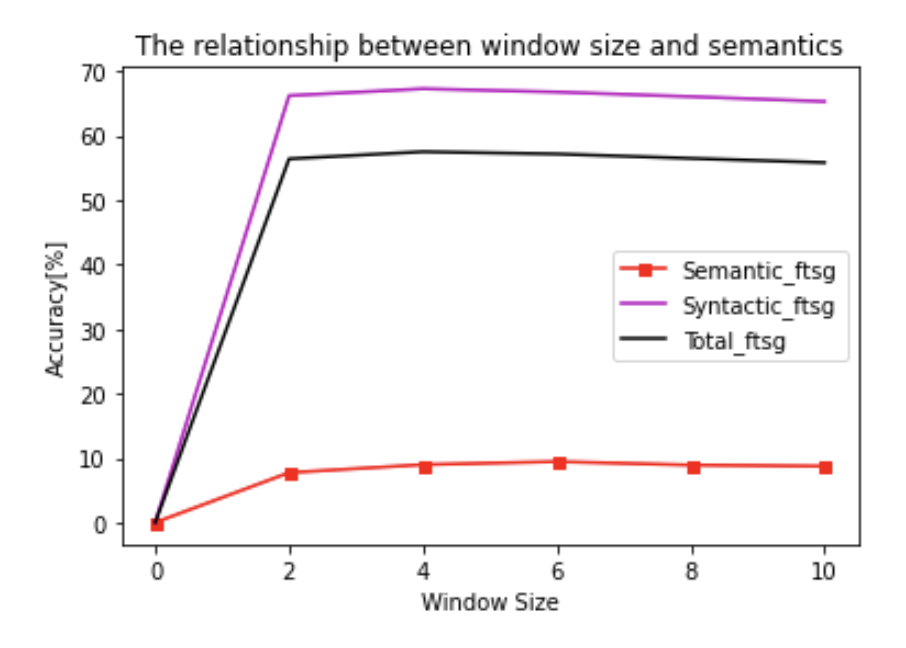

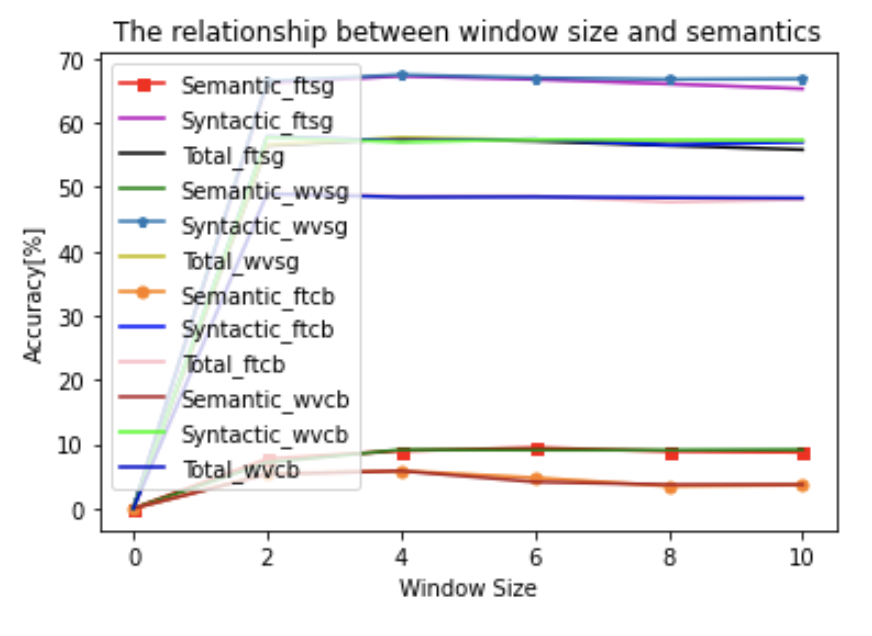

## 3.2. Performance Evaluation


You are required to provide the table with precision, recall, f1 of test set.
Note that it will not be marked if you do not display it in the ipynb file.


(*Please show your empirical evidence*)
* The above is the evaluation result of Bi-RNN model, and the following is the evaluation result of Bi-LSTM model. It can be seen that the evaluation result of Bi-LSTM is better than that of Bi-RNN model. I guess it may be because Bi-LSTM performs a memory filtering model. Some of the important information is retained and those unimportant information is removed. The RNN model does not perform as well as the LSTM model in dealing with long sequences. But I think the reason for doing bi-directional causes the RNN performance is not particularly bad. Removing expressions is much more accurate than not removing expressions. I guess it may be that more and more effective features are retained.



In [51]:
#[lab4][lab5]
import time
since = time.time()
def train_model(criterion, model, optimizer):
  for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,sent_encoded_train.shape[0],batch_size):
        input_batch = sent_encoded_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])] 
        target_batch = label_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])]  
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)  
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device) 

        model.train()
        optimizer.zero_grad()
        outputs = model(input_batch_torch) 
        loss = criterion(outputs, target_batch_torch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    predicted = torch.argmax(outputs, 1)  
    acc = accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
    #print('Epoch: %d, train loss: %.5f, train_acc:%.2f'%(epoch + 1, train_loss, acc))

  #print('Finished Training')
  ## Prediction

  model.eval()
  outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device)) 
  predicted2 = torch.argmax(outputs2, 1)
  return predicted2
time_elapsed = time.time() - since
print('The code run {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#=======
  # from sklearn.metrics import classification_report
  # print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))


The code run 0m 0s


In [52]:
#[lab4][lab5]
seq_length = doc_length_list[max_index]          
n_input = len(input_train[0][0])              
n_class = len(unique_labels)                      #2

#[final]
n_hidden = 232                                  #128 64 ；128； 256   512
batch_size = 512                                #500 
total_epoch = 15                                #10  
learning_rate = 0.001                           # 1e-4 == 0.001 le-3 == 0.01 #0.1  0.05


# n_hidden = 128                                  #128
# batch_size = 256                                #500 
# total_epoch = 20                                #10
# learning_rate = 0.001                           # 1e-4 == 0.001 le-3 == 0.01 #0.1  0.05

class Bi_RNN_Model(nn.Module):
    def __init__(self):
        super(Bi_RNN_Model, self).__init__()
        # set the bidirectional to True
        self.rnn = nn.RNN(n_input, n_hidden, batch_first =True, bidirectional=True)     #, dropout = 0.5
        self.linear = nn.Linear(2*n_hidden,n_class) 
       
    def forward(self, x):        
        x, h_n = self.rnn(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        output = self.linear(hidden_out)
        return output

In [53]:
#[lab4][lab5]
import time
since = time.time()
from sklearn.metrics import classification_report
#Bi-RNN

criterion1 = nn.CrossEntropyLoss()
model1 = Bi_RNN_Model().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)

pre_RNN = train_model(criterion1,model1,optimizer1)
print(classification_report(label_test, pre_RNN.cpu().numpy(),digits=4))

#Bi-LSTM
criterion2 = nn.CrossEntropyLoss()
model2 = Bi_LSTM_Model().to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)

pre_LSTM = train_model(criterion2,model2,optimizer2)
print(classification_report(label_test, pre_LSTM.cpu().numpy(),digits=4))

time_elapsed = time.time() - since
print('The code run {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


              precision    recall  f1-score   support

           0     0.9000    0.9810    0.9388      1000
           1     0.9791    0.8910    0.9330      1000

    accuracy                         0.9360      2000
   macro avg     0.9396    0.9360    0.9359      2000
weighted avg     0.9396    0.9360    0.9359      2000

              precision    recall  f1-score   support

           0     0.9867    0.9630    0.9747      1000
           1     0.9639    0.9870    0.9753      1000

    accuracy                         0.9750      2000
   macro avg     0.9753    0.9750    0.9750      2000
weighted avg     0.9753    0.9750    0.9750      2000

The code run 6m 26s


**Without delete expression**

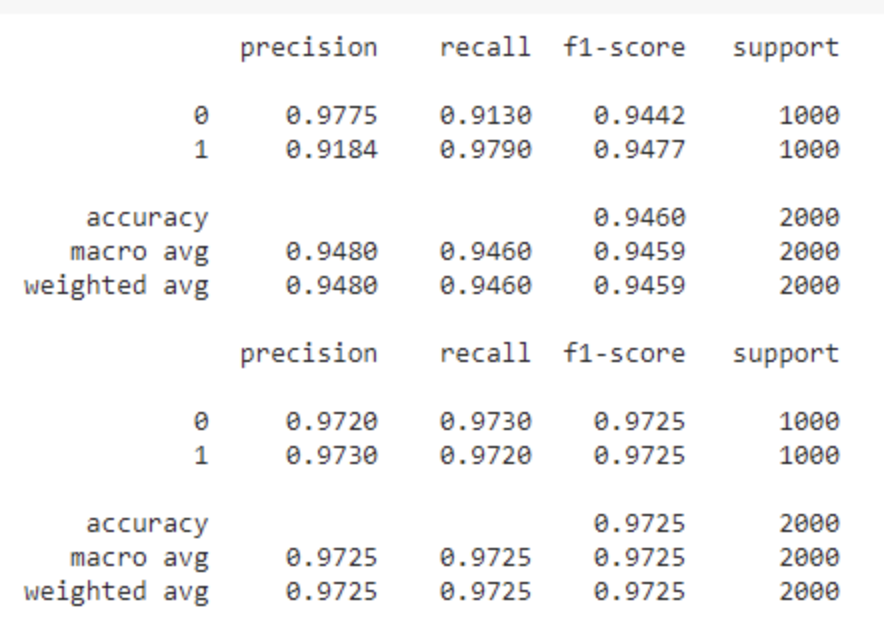

**delete expression**

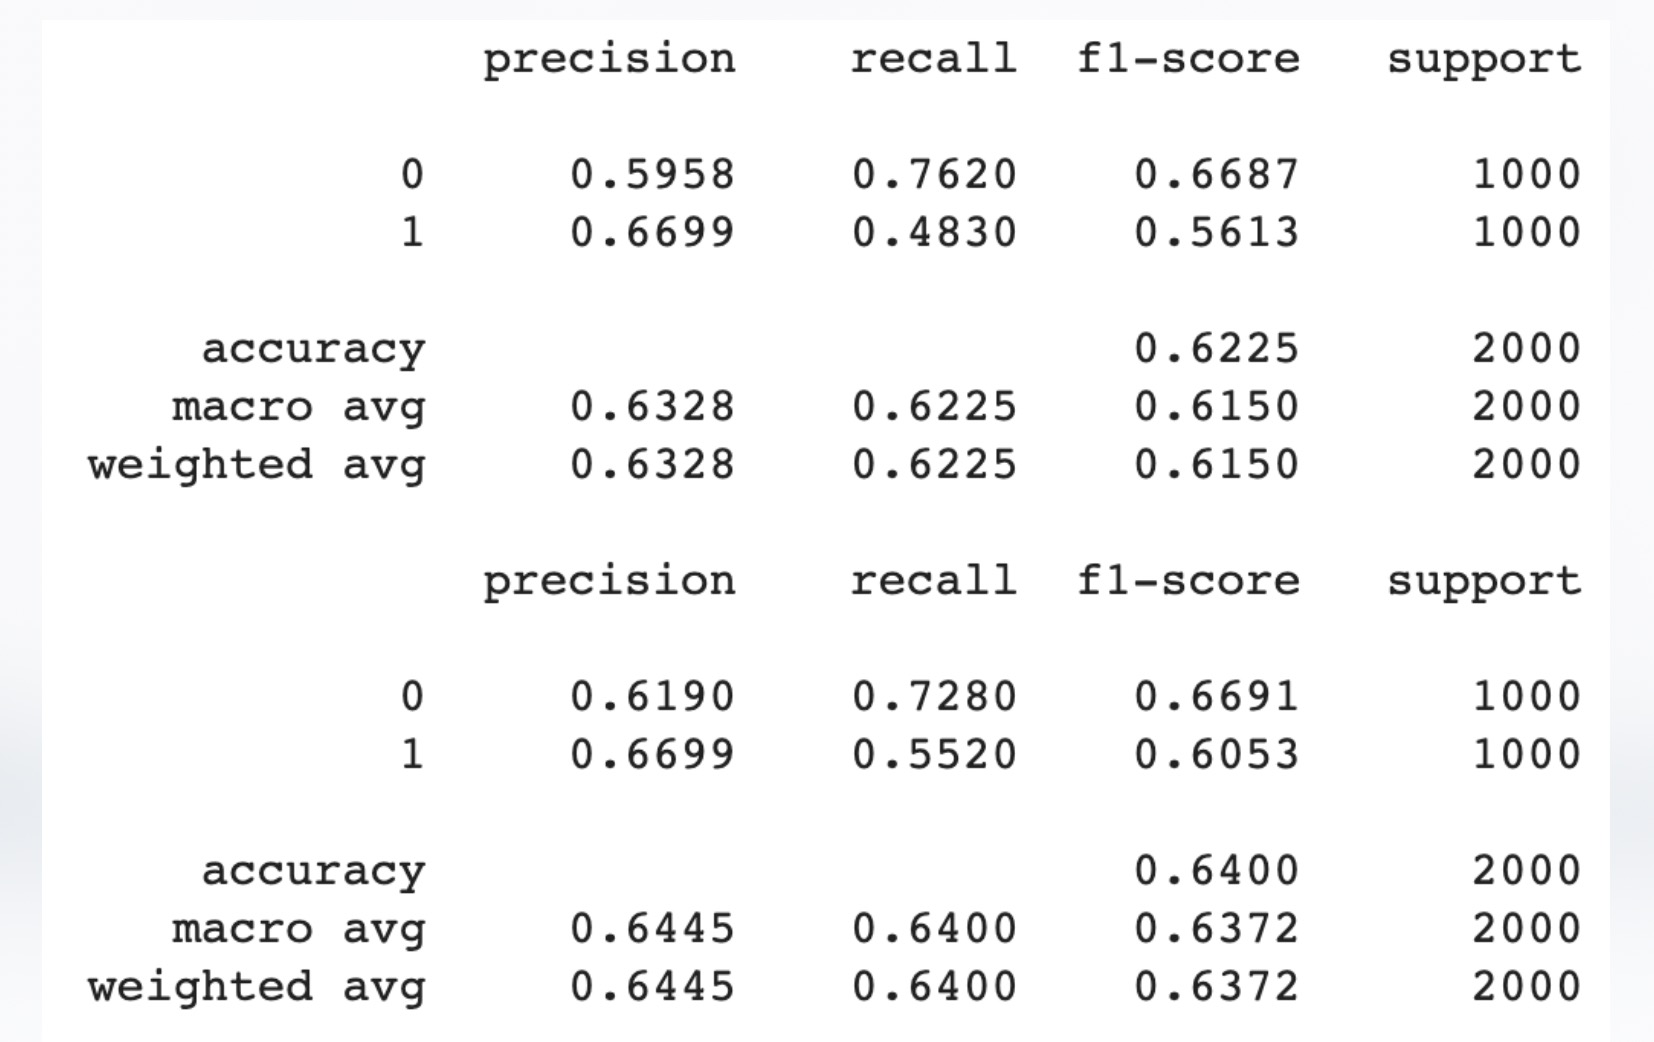

## 3.3. Hyperparameter Testing
*You are required to draw a graph(y-axis: f1, x-axis: epoch) for test set and explain the optimal number of epochs based on the learning rate you have already chosen.* Note that it will not be marked if you do not display it in the ipynb file.


(*Please show your empirical evidence*)
* 3.3.1 The picture shows that the learning rate is too large to go to the local minimum, only by reducing the learning rate can we. I finally chose a learning rate of 0.001, and the F1-score was more stable in every test. Because I set a larger batch_size, I have already explained this before. The visualisation shows that the F1-score is highest for epoch=14. I suspect that this may be because the possibility of data leakage was created, perhaps too many training sessions and the model has memory. It may be necessary to use cross-validation or confusion matrices for testing in future work.
* 3.3.2 It is evident that at learning rate = 0.05, the F1-score can be felt bouncing back and forth around the local minimum.
* 3.3.3 I have reduced the hidden element dimension. It can be seen that the F1-score is getting better. Multiple hidden elements will keep the classification effect close to the decision boundary. If too large it may lead to overfitting and more attempts will be made in future learning.
* Overall too large a learning rate setting will cause the network to fail to converge. It hovers around the local optimal solution (saddle point), i.e. it jumps directly over the lowest point to the other side of the symmetry, ignoring the location of the optimal solution. If the learning rate is too small it will result in too slow convergence. I should increase the number of epochs for training the model in subsequent work.
I guess it is also possible that the addition of the expression feature has caused the feature to over-fit the true value and there is a possibility of over-fitting. I will test my model with more datasets in the future.


In [58]:
#[lab4][lab5]
seq_length = doc_length_list[max_index]           
n_input = len(input_train[0][0])              
n_class = len(unique_labels)                           #2

#[finial]
n_hidden = 232                                        #128 64 ；128； 256   512
batch_size = 512                                      #500 
total_epoch = 15                                      #10   
learning_rate = [0.05, 0.001]                          # 1e-4 == 0.001 le-3 == 0.01 #0.1  0.05//  [0.05,0.01,0.005,0.001]  
#learning_rate = [0.05,0.01,0.005,0.001]  


# n_hidden = 232                                        #128 64 ；128； 256   512
# batch_size = 512                                      #500 
# total_epoch = 15                                      #10   
# learning_rate = [0.05]                          # 1e-4 == 0.001 le-3 == 0.01 #0.1  0.05//  [0.05,0.01,0.005,0.001]  
# #learning_rate = [0.05,0.01,0.005,0.001]  



In [60]:
# [lab4][lab5]
from sklearn.metrics import f1_score
import time
line_lr = []
since = time.time()
for learn in range(len(learning_rate)):
  epoch_f1 = []
  criterion = nn.CrossEntropyLoss()
  model = Bi_LSTM_Model().to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate[learn])

  for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,sent_encoded_train.shape[0],batch_size):
        input_batch = sent_encoded_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])] 
        target_batch = label_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])]  
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)  
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device) 

        model.train()
        optimizer.zero_grad()
        outputs = model(input_batch_torch)   
        loss = criterion(outputs, target_batch_torch) 
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    predicted = torch.argmax(outputs, 1)      
    acc = accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
  
    model.eval()
    outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device)) 
    predicted2 = torch.argmax(outputs2, 1)
    #print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
    f1 = f1_score(label_test, predicted2.cpu().numpy(),average='macro') 
    epoch_f1.append(f1)
    #print(epoch_f1)
  line_lr.append(epoch_f1)
print(line_lr)
time_elapsed = time.time() - since
print('The code run {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))



[[0.3333333333333333, 0.3333333333333333, 0.7040384208292743, 0.7325204752953813, 0.8169594503656324, 0.9364866463173882, 0.9499579146061838, 0.9629990749768744, 0.9714948049281982, 0.9624995406193726, 0.980999980999981, 0.9639756475377355, 0.9524331090596152, 0.9729947069625647, 0.9819978217364301], [0.8003597577968635, 0.8954884776046559, 0.922476258354121, 0.9429999429999429, 0.9474757206518714, 0.9504964233665882, 0.952999811999248, 0.957995799579958, 0.9604864764965809, 0.9654980592658338, 0.9679945910858935, 0.9694993823624929, 0.968499614120273, 0.9634888184506505, 0.9734970780528553]]
The code run 36m 13s


You can uncomment it if you want to test it. I have changed the parameters, so the order of the final test results may not match the order in the diagram.

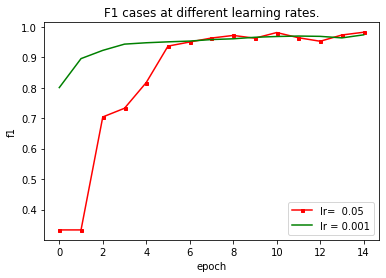

In [61]:
#  x is the epoch y is the f1 test set command+/
import matplotlib.pyplot as plt
#for epoch in range(total_epoch):  
#x = [5, 10, 15, 20, 25, 30, 35, 40]
#y = [17, 24, 29, 36, 38, 47, 59, 80]
#[1,0.5,0.1,0.05,0.01,0.005,0.001] // [0.05,0.01,0.005,0.001]
x = [epoch for epoch in range(total_epoch)]
y1 = [f1 for f1 in line_lr[0]]
y2 = [f1 for f1 in line_lr[1]]
#y3 = [f1 for f1 in line_lr[2]]
#y4 = [f1 for f1 in line_lr[3]]
# y5 = [f1 for f1 in line_lr[4]]
# y6 = [f1 for f1 in line_lr[5]]
# y7 = [f1 for f1 in line_lr[6]]
plt.plot(x,y1,'rs-',markersize =3,label = 'lr=  0.05')        #0.05

plt.plot(x,y2,'g-',markersize =3, label = 'lr = 0.001')        #0.01  0.001
#plt.plot(x,y3,'b-',markersize =3, label = 'lr = 0.01')        #0.005  0.001
#plt.plot(x,y4,'y-',markersize =3, label = 'lr = 0.005')       #0.001
# plt.plot(x,y5,'c-',markersize =3, label = 'lr = 0.01') 
# plt.plot(x,y6,'m-',markersize =3, label = 'lr = 0.005')
# plt.plot(x,y7,'k-',markersize =3, label = 'lr = 0.001') 
plt.xlabel('epoch')
plt.ylabel('f1')
plt.title('F1 cases at different learning rates.')
plt.legend()                                                   #Let the label show
plt.show()
# precision: TP/(TP+FP)
#recall


**3.3.1 The F1-score of the four learning rates with different epochs.**

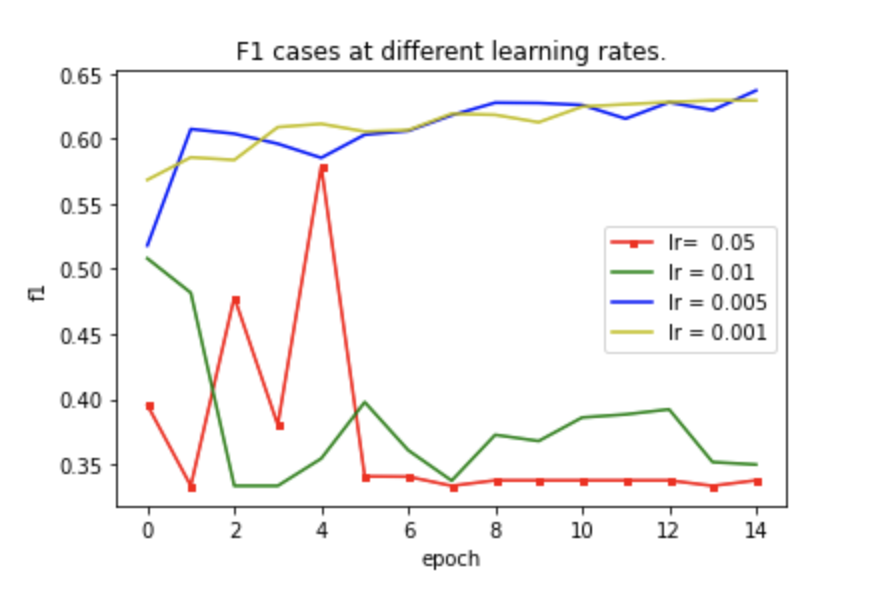

**3.3.2 The F1-score for different epochs with three learning rates.**

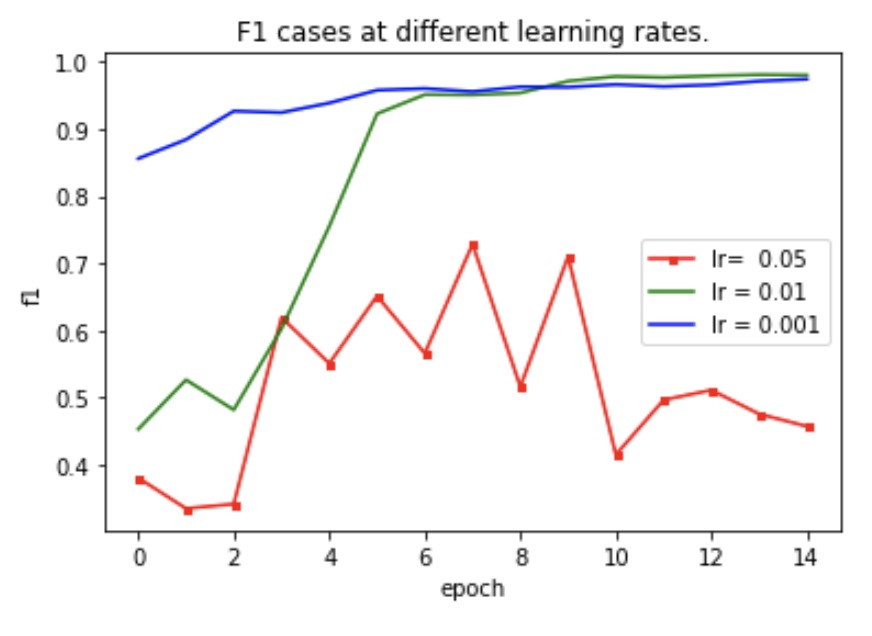

**3.3.3 The F1-score of the case of reducing the hidden size with two learning rates and different epochs.** n_hidden = 64

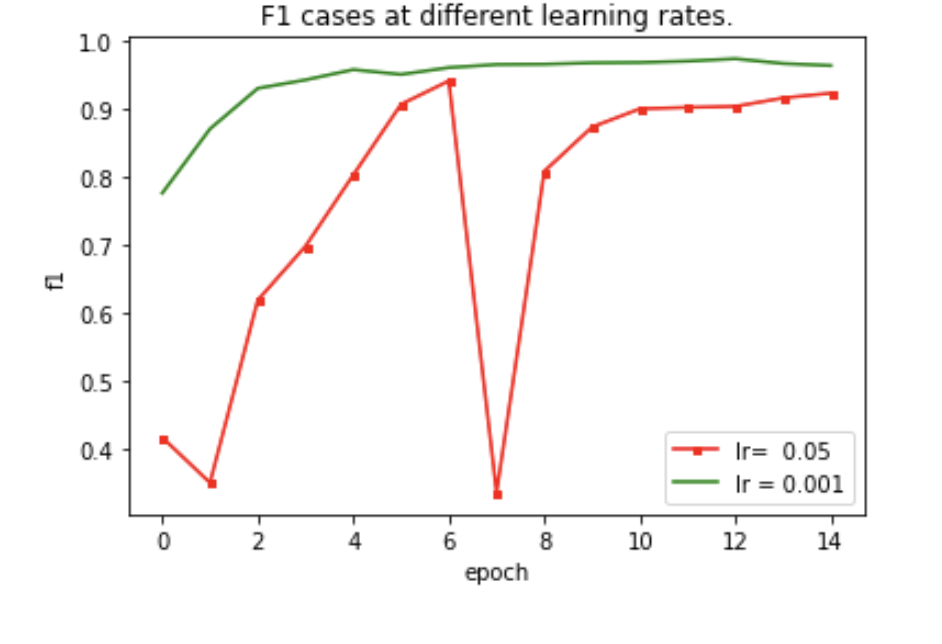

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed* 

In [ ]:
# If you used OOP style, use this section